# $k$ Nearest Neighbors Classifier

In this notebook will be some additional problems regarding the $k$-nearest neighbors classifier. This material corresponds to `Lectures/Supervised Learning/Classification/2. k Nearest Neighbors Classifier`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

##### 1. The "perfect" iris classifier

##### a.

Load the iris data set, then perform a train test split. Fit a $k$-nearest neighbors classifier on the training data with $k=1$. What is the accuracy of this model on the training set?

In [2]:
## to get the iris data
from sklearn.datasets import load_iris

## import train_test_split
from sklearn.model_selection import train_test_split

## Load the data
iris = load_iris()
iris_df = pd.DataFrame(iris['data'],columns = ['sepal_length','sepal_width','petal_length','petal_width'])
iris_df['iris_class'] = iris['target']

## Making the split
iris_train, iris_test = train_test_split(iris_df, 
                                            random_state=431,
                                            shuffle=True,
                                            test_size=.2,
                                            stratify=iris_df['iris_class'])

##### Sample Solution

In [3]:
## import the model
from sklearn.neighbors import KNeighborsClassifier

In [4]:
knn = KNeighborsClassifier(1)

knn.fit(iris_train[['sepal_length','sepal_width','petal_length','petal_width']], iris_train['iris_class'])

KNeighborsClassifier(n_neighbors=1)

In [5]:
## getting the accuracy
pred = knn.predict(iris_train[['sepal_length','sepal_width','petal_length','petal_width']])

np.sum(pred==iris_train['iris_class'])/len(iris_train)

1.0

##### b.

The training accuracy of a $k$-nearest neighbors model with $k=1$ is always $1$, why is that?

##### Sample Solution

The $k$NN classifier will assign a class by looking at the proportion of a point's closest neighbors in the training space. When $k=1$ this means that we find the single training point that is closest to the point we want to predict. If that point is already in the training set, then we would automatically just assign its class as the prediction, guaranteeing perfect training performance.

##### 2. Bias-Variance Tradeoff for KNN

With $k$-nearest neighbors the complexity of the model is primarily controlled by the number of neighbors, $k$, considered when making a prediction.

Which model do you expect to have the highest variance and which one do you expect to have the highest bias:
- A model with $k=1$,
- A model with $k=n$, where $n$ is the number of observations in the training set?

In general which direction should you move $k$ to increase the bias, which direction to increase the variance?

##### Sample Solution

The model with $k=1$ would have the highest variance, the model with $k=n$ would have the highest bias.

To see this consider what happens in either scenario:
- When $k=1$, each point will be assigned the class of the training point to which it is closest. Such a model would thus be very sensitive to what the training data turns out to be. Because variance of the model measures how much the model changes with new randomly drawn training data, this model would have high variance.
- When $k=n$ a new data point is predicted using the entire data set. This means that any point we would want to predict is just predicted to be the class most represented in the data set. If your training set is large enough, this should not vary too much as you randomly draw different training sets. This model would thus have the lowest variance, and hence the largest bias.

In general lower values of $k$ result in knn models with higher variance, while higher values of $k$ result in $k$NN models with higher bias.

##### 3. Weighted Votes

Sometimes it may be preferable to weight the votes, meaning that some of the $k$ nearest neighbors get more of a say in the predicted class. One common way to weight votes is by the inverse of the distance to the point you are trying to predict.

Suppose you want to predict an output variable, $y$, with $\mathcal{C}$ possible classes, using the $k$ nearest neighbors algorithm with a distance metric denoted with a $d$ (a standard choice is the euclidean distance $d(a,b) = \sqrt{\sum_{i=1}^m (a_i - b_i)^2}$ for two vectors $a,b \in \mathbb{R}^m$). Then the weighted version of $k$NN predicts that a new point $X^*$ would be the class $l$ for which:

$$
v_l = \sum_{i \in \mathcal{N}(X^*)} \frac{1}{d(X^*, X_i)} 1_{\left\lbrace y_i = l\right\rbrace},
$$

where $\mathcal{N}(X^*)$ is the set of training points representing the $k$-nearest neighbors of $X^*$ and $1_{\left\lbrace y_i = l\right\rbrace}$ is $1$ when $y_i = l$ and $0$ when $y_i\neq l$.

For the iris data set perform cross-validation to investigate whether weighted $k$NN outperforms unweighted $k$NN in terms of the accuracy. Do this for $k=1,\dots,10$.

Look at the `KNeighborsClassifier` documentation, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html">https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html</a> to see how to implement weighted $k$NN. 

##### Sample Solution

In [6]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

In [7]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1560)
neighbors = range(1,21)

knn_cvs = np.zeros((5,len(neighbors)))
wknn_cvs = np.zeros((5,len(neighbors)))

i = 0
for train_index, test_index in kfold.split(iris_train[['sepal_length','sepal_width','petal_length','petal_width']],
                                              iris_train['iris_class']):
    iris_train_train = iris_train.iloc[train_index]
    iris_holdout = iris_train.iloc[test_index]
    j = 0
    for n in neighbors:
        knn = KNeighborsClassifier(n)
        wknn = KNeighborsClassifier(n, weights='distance')
        
        knn.fit(iris_train_train[['sepal_length','sepal_width','petal_length','petal_width']],
                   iris_train_train['iris_class'])
        wknn.fit(iris_train_train[['sepal_length','sepal_width','petal_length','petal_width']],
                    iris_train_train['iris_class'])
        
        knn_pred = knn.predict(iris_holdout[['sepal_length','sepal_width','petal_length','petal_width']])
        wknn_pred = wknn.predict(iris_holdout[['sepal_length','sepal_width','petal_length','petal_width']])
        
        knn_cvs[i,j] = accuracy_score(iris_holdout['iris_class'], knn_pred)
        wknn_cvs[i,j] = accuracy_score(iris_holdout['iris_class'], wknn_pred)
        j= j + 1
    i = i + 1

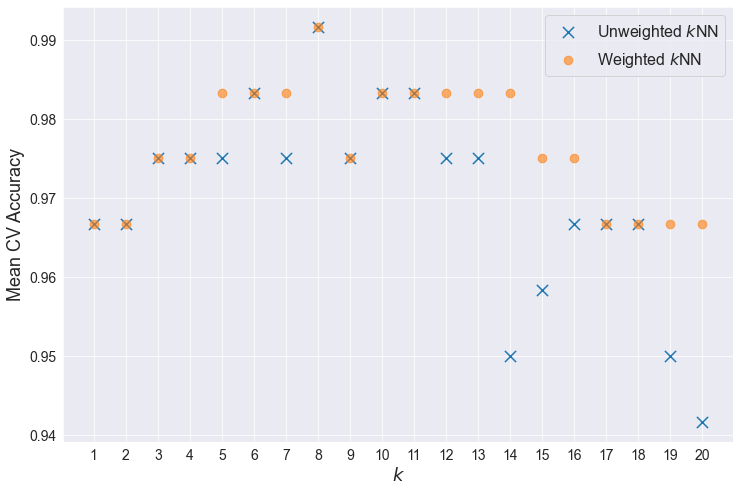

In [8]:
sns.set_style("darkgrid")
plt.figure(figsize=(12,8))

plt.scatter(neighbors, np.mean(knn_cvs, axis=0), label="Unweighted $k$NN", s=125, alpha=1, marker='x')
plt.scatter(neighbors, np.mean(wknn_cvs, axis=0), label="Weighted $k$NN", s=75, alpha=.6)

plt.xticks(neighbors, fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("$k$", fontsize=18)
plt.ylabel("Mean CV Accuracy", fontsize=18)
plt.legend(fontsize=16)

plt.show()

##### 4. Training and prediction times

How is the training time for $k$-nearest neighbors impacted by the size of the training set, $n$, that is, as $n$ gets larger what happens to the training time?


What happens to the prediction time, the time it takes for the algorithm to make a prediction, as $n$ gets larger?

##### Sample Solution

The size of the training set has no impact on the training time for the $k$NN model. This is because the model does not have a proper training step because there are no model parameters to estimate.

On the other hand the time it takes the $k$NN make a prediction is greatly impacted by the size of $n$. This is because the larger the training set, the more training points that need to be searched for the $k$-nearest neighbors. If your implementation of the algorithm calculates the distance to every single training point, then calculating the distances takes $n T$ seconds, where $T$ is taken to be the time to calculate the distance between two points. $T$ depends upon the number of features for your data.

There are algorithms that do not calculate all the distances, namely the ball tree and kd tree algorithms, that are quicker than calculating all the possible distances, but those still have a computation time that is dependent on $n$. To learn more about those algorithms check out the `sklearn` documentation.

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2023.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)